## Mask R-CNN Image Segmentation
aside from the bounding boxes, the model is also able to predict segmentation masks for each instance of a class in the image.

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

In [23]:
%%cmd  # bash por cmd
runas apt install -y protobuf-compiler    # sudo don't exist in  windows
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
copy object_detection/packages/tf2/setup.py .  # cp por copy
python -m pip install . 

Microsoft Windows [Version 10.0.19041.746]
(c) 2020 Microsoft Corporation. All rights reserved.

(base) C:\Users\Carmona\tmp\ADVANCE TF- COURSE 1\ADVANCE TF- COURSE 3\WEEK3\MASK-RCNN image segmenttion>runas apt install -y protobuf-compiler    # sudo don't exist in  windows

(base) C:\Users\Carmona\tmp\ADVANCE TF- COURSE 1\ADVANCE TF- COURSE 3\WEEK3\MASK-RCNN image segmenttion>cd models/research/

(base) C:\Users\Carmona\tmp\ADVANCE TF- COURSE 1\ADVANCE TF- COURSE 3\WEEK3\MASK-RCNN image segmenttion\models\research>protoc object_detection/protos/*.proto --python_out=.

(base) C:\Users\Carmona\tmp\ADVANCE TF- COURSE 1\ADVANCE TF- COURSE 3\WEEK3\MASK-RCNN image segmenttion\models\research>copy object_detection/packages/tf2/setup.py .  # cp por copy
The syntax of the command is incorrect.

(base) C:\Users\Carmona\tmp\ADVANCE TF- COURSE 1\ADVANCE TF- COURSE 3\WEEK3\MASK-RCNN image segmenttion\models\research>python -m pip install . 

(base) C:\Users\Carmona\tmp\ADVANCE TF- COURSE 1\ADVANCE 

ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [24]:
# import
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

tf.get_logger().setLevel('ERROR')

%matplotlib inline

In [6]:
# load and convert an image to a numpy array
def load_image_into_numpy_array(path):
    image=None
    if (path.startswith("http")):
        response= urlopen(path)
        image_data= response.read()
        image_data= BytesIO(image_data)
        image= Image.open(image_data)
    else:
        image_data= tf.io.gfile.GFile(path,"rb").read()
        image= Image.open(BytesIO(image_data))
        
    (im_width, im_height)= (image.size)
    return np.array(image.getdata()).reshape((1,im_height,im_width,3)).astype(np.uint8)


# dictionary with image tags as keys, and image paths as values
TEST_IMAGES = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # By 663highland, Source: https://commons.wikimedia.org/wiki/File:Kitano_Street_Kobe01s5s4110.jpg
  'Street' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg'
}
        

In [7]:
## Load the Model
model_handle= "https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1"
hub_model= hub.load(model_handle)

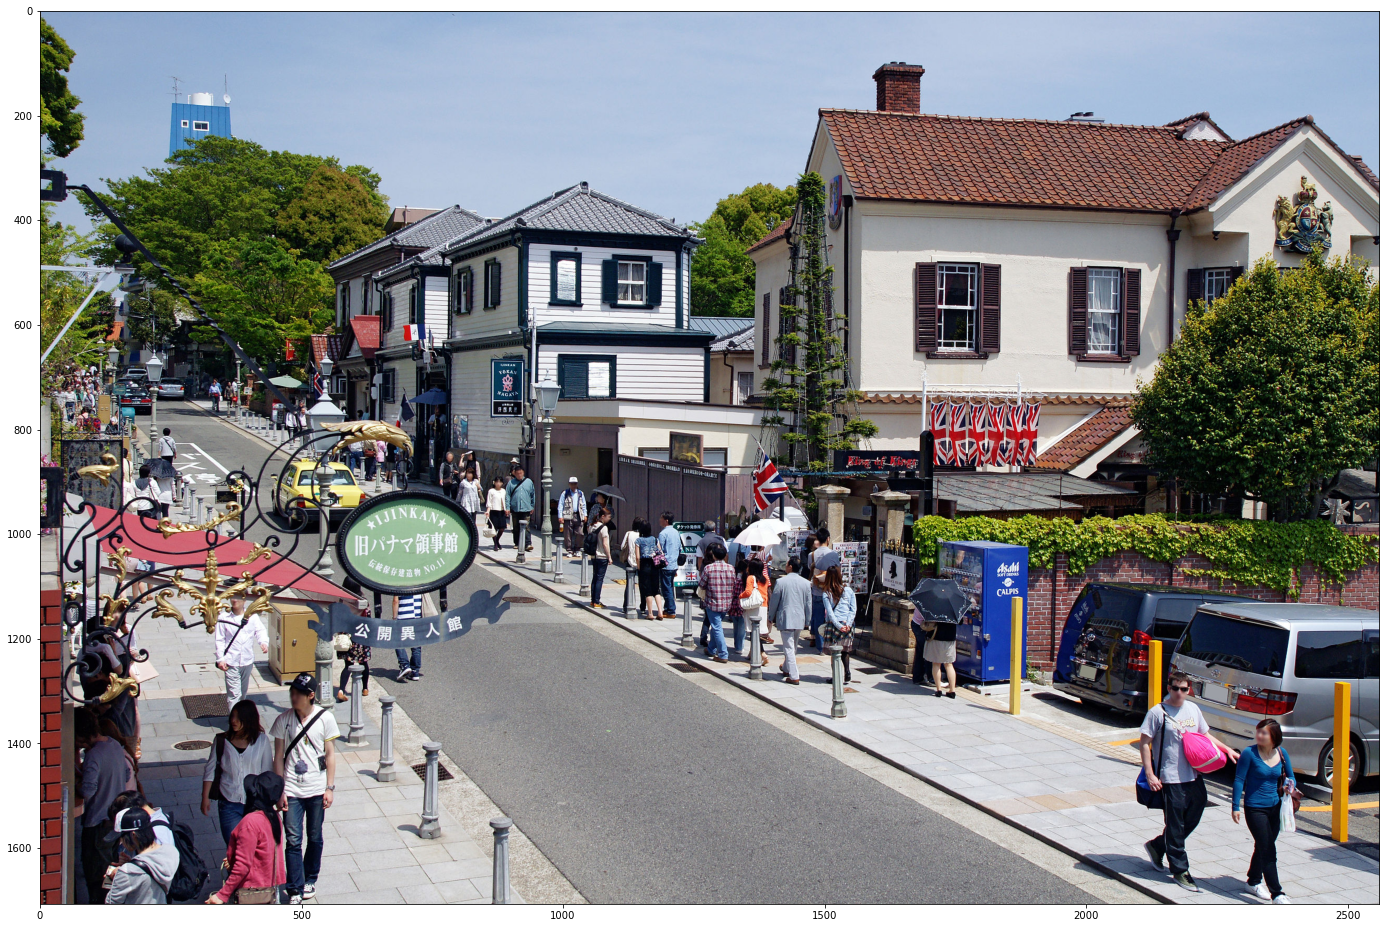

In [15]:
# Choose one and use as key for TEST_IMAGES below: 
# ['Beach', 'Street', 'Dogs','Phones']
 
image_path= TEST_IMAGES["Street"]
image_np= load_image_into_numpy_array(image_path)
plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [19]:
result= hub_model(image_np)
# output values are tensors and we only need the numpy() 
# parameter when we visualize the results
result= {key:value.numpy() for key,value in result.items()}
for key in result.keys():
    print(key)

anchors
box_classifier_features
class_predictions_with_background
detection_anchor_indices
detection_boxes
detection_classes
detection_masks
detection_multiclass_scores
detection_scores
final_anchors
image_shape
mask_predictions
num_detections
num_proposals
proposal_boxes
proposal_boxes_normalized
raw_detection_boxes
raw_detection_scores
refined_box_encodings
rpn_box_encodings
rpn_box_predictor_features
rpn_features_to_crop
rpn_objectness_predictions_with_background


## Vizualising the results
we need to create the "category_index" dicc that contains the class ID and names
the model was trained in COCO2017 dataset, the API package has the labels saved in a different format (i.e. mscoco_label_map.pbtxt) 



In [20]:
path_to_labels= './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index= label_map_util.create_category_index_from_labelmap(path_to_labels,use_display_name=True)
r
# sample output
print(category_index[1])
print(category_index[2])
print(category_index[4])

{'id': 1, 'name': 'person'}
{'id': 2, 'name': 'bicycle'}
{'id': 4, 'name': 'motorcycle'}


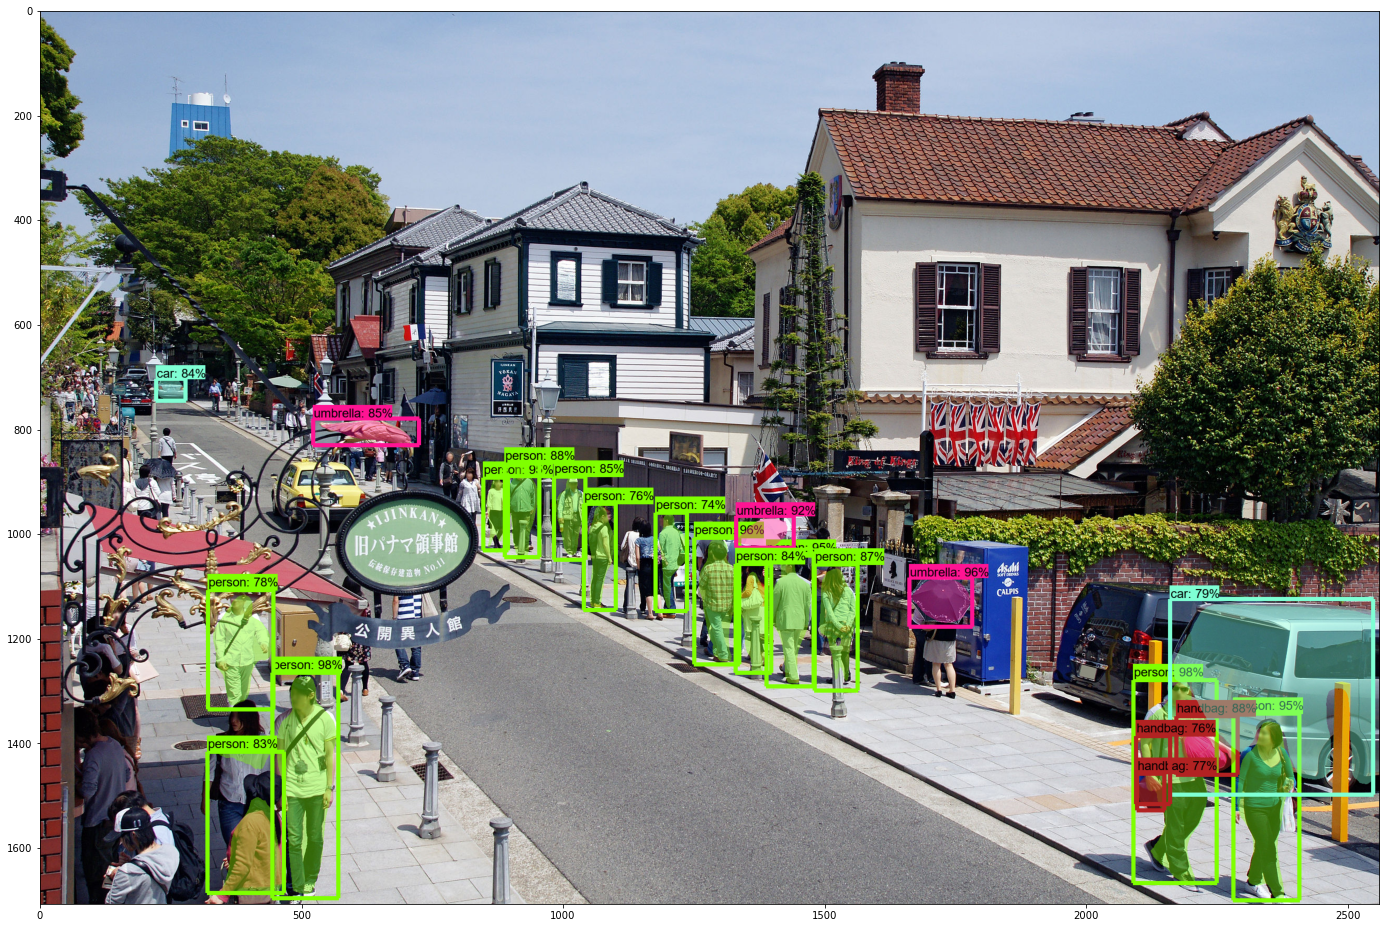

In [26]:
# Handle models with masks:
label_id_offset = 0
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
    #convert np.arrays to tensor
    detection_masks= tf.convert_to_tensor(result["detection_masks"][0])
    detection_boxes= tf.convert_to_tensor(result["detection_boxes"][0])
    
  # reframe the the bounding box mask to the image size.
    detection_mask_reframed= utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])
    
    # filter mask pixel values that are above a specified threshold
    detection_masks_reframed = tf.cast(detection_mask_reframed > 0.6,
                                      tf.uint8)
    # get the numpy array
    result['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    
# overlay labeled boxes and segmentation masks on the image
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.70,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()
    
    